(a) The parameters of Gaussian Mixture Model (GMM) can be estimated via the EM algorithm. Show that the alternating algorithm for k-means (in Lec. 11) is a special case of the EM algorithm and show the corresponding objective functions for E-step and M-step.

(b) Download the Old Faithful Geyser Dataset. The data file contains 272 observations of (eruption time, waiting time). Treat each entry as a 2 dimensional feature vector. Parse and plot all
data points on 2-D plane

In [26]:
import numpy as np
from scipy.stats import multivariate_normal as norm
from matplotlib import pyplot as plt

In [82]:
#Read Data
dataset = open("faithful.dat", "r")
lines = dataset.read()
lines = lines.split("\n")

X = np.array([np.array(x.split()[1:]) for x in lines][:-1]).astype(float)

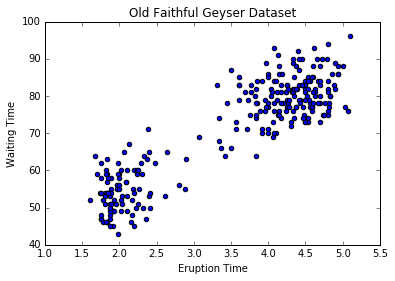

In [31]:
plt.scatter(X[:,0], X[:,1])
plt.title("Old Faithful Geyser Dataset")
plt.xlabel("Eruption Time")
plt.ylabel("Waiting Time")
plt.show()

(c)Implement a bimodal GMM model to fit all data points using EM algorithm. Explain the reasoning behind your termination criteria. For this problem, we assume the covariance matrix
is spherical (i.e., it has the form of σ 2 I for scalar σ) and you can randomly initialize Gaussian
parameters.

In [198]:
def bimodal_gmm():
    #Initialization
    k = 2
    n, d = np.shape(X)

    mu1 = X[np.random.randint(n, size=1),:][0]
    mu2 = X[np.random.randint(n, size=1),:][0]

    sigma1 = np.eye(d)
    sigma2 = np.eye(d)

    pi_hat = np.asarray([1/k] * k)
    counter = 0
    gamma_last = []
    
    mu_history = []
    
    while(True):
        #Expectation
        gamma = []
        for i in range(n):
            numerator = pi_hat * norm.pdf(X[i], mu2, sigma2)
            denominator = ((1-pi_hat)* norm.pdf(X[i], mu1, sigma1))+numerator
            gamma_i = numerator/denominator
            if np.isnan(gamma_i).any():
                gamma_i = np.array([0]*2)
            gamma.append(gamma_i)
        gamma = np.asarray(gamma)

        #Maximization
        mu1_numerator = sum([np.multiply((1-gamma[i]),X[i]) for i in range(n)])
        mu1_denominator = sum([(1-gamma[i]) for i in range(n)])
        mu1 = mu1_numerator/mu1_denominator

        mu2_numerator = sum([np.multiply(gamma[i],X[i]) for i in range(n)])
        mu2_denominator = sum([gamma[i] for i in range(n)])
        mu2 = mu2_numerator/mu2_denominator
        
        mu_history.append([mu1, mu2])
        
        sigma1 = sum([np.dot(np.transpose(np.asmatrix(1-gamma[i])),np.asmatrix(np.square(X[i]-mu1))) for i in range(n)])/mu1_denominator
        sigma2 = sum([np.dot(np.transpose(np.asmatrix(gamma[i])),np.asmatrix(np.square(X[i]-mu2))) for i in range(n)])/mu2_denominator

        #Make Spherical
        sigma1 = np.multiply(sigma1, np.eye(d))
        sigma2 = np.multiply(sigma2, np.eye(d))
        
        pi_hat = sum([gamma[i]/n for i in range(n)])

        #Check Convergence
        counter += 1
        if(counter > 1):
            if(np.allclose(gamma, gamma_last)):
                return(counter, mu_history)
        gamma_last = gamma


In [199]:
print(bimodal_gmm()[0])

13


Termination criteria: That the change in gamma between two iterations is sufficiently small.
Reasoning: Gamma is the responsibility for both cluter centers. If the change in responsibility is negligible, then the GMM is approaching "equilibrium."

(c. contd) For evaluation purposes, please submit the following figures: <br>
• Plot the trajectories of two mean vectors in 2 dimensions (i.e., coordinates vs. iteration). <br>
• Run your program for 50 times with different initial parameter guesses. Show the distribution of the total number of iterations needed for algorithm to converge.

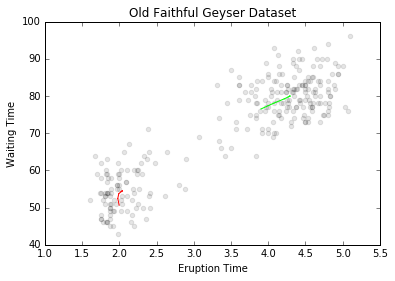

In [146]:
plt.clf()
plt.scatter(X[:,0], X[:,1], c=[0,0,0,.1], edgecolors="face")
plt.title("Old Faithful Geyser Dataset")
plt.xlabel("Eruption Time")
plt.ylabel("Waiting Time")
mu_hist = bimodal_gmm()[1]
first = True
last = []
for mu_set in mu_hist:
    if(first):
        first = False
    else:
        plt.plot([mu_set[0][0],last[0][0]], [mu_set[0][1],last[0][1]], c=[1,0,0])
        plt.plot([mu_set[1][0],last[1][0]], [mu_set[1][1],last[1][1]], c=[0,1,0])
    last = mu_set
plt.savefig("means.png")
plt.show()

In [155]:
iterations = {}
for x in range(50):
    iteration = bimodal_gmm()[0]
    if iteration in iterations:
        iterations[iteration] += 1
    else:
        iterations[iteration] = 1

/usr/lib/python3.5/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in true_divide


OrderedDict([(8, 4), (9, 4), (10, 9), (11, 7), (12, 3), (13, 7), (14, 7), (15, 7), (17, 2)])
odict_keys([8, 9, 10, 11, 12, 13, 14, 15, 17])


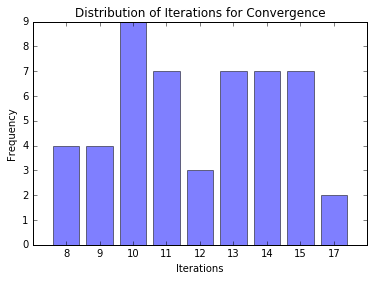

In [167]:
import collections
iterations = collections.OrderedDict(sorted(iterations.items()))

print(iterations)
y_pos = range(len(iterations))
performance = iterations.values()

print(iterations.keys())
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, iterations.keys())
plt.ylabel('Frequency')
plt.xlabel('Iterations')
plt.title('Distribution of Iterations for Convergence')
 
plt.savefig("distribution.png")
plt.show()

(d) Repeat the task in (c) but with the initial guesses of the parameters generated from the following process: <br>
• Run a k-means algorithm over all the data points with K = 2 and label each point with
one of the two clusters. <br>
• Estimate the first guess of the mean and covariance matrices using maximum likelihood
over the labeled data points. <br>
• Compare the algorithm performances of (c) and (d).

In [192]:
from sklearn.cluster import KMeans

In [215]:
#Read Data
dataset = open("faithful.dat", "r")
lines = dataset.read()
lines = lines.split("\n")

X = np.array([np.array(x.split()[1:]) for x in lines][:-1]).astype(float)

In [218]:
def bimodal_gmm2():
    #K-means
    k = 2
    kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
    clusters = kmeans.predict(X)
    centers = kmeans.cluster_centers_

    gamma = []
    for item in clusters:
        if item == 0:
            gamma.append([1]*2)
        else:
            gamma.append([0]*2)
    gamma = np.asarray(gamma)

    #Initialization
    n, d = np.shape(X)

    mu1 = centers[0]
    mu2 = centers[1]

    sigma1 = sum([np.dot(np.transpose(np.asmatrix(1-gamma[i])),np.asmatrix(np.square(X[i]-mu1))) for i in range(n)])/sum([(1-gamma[i]) for i in range(n)])
    sigma2 = sum([np.dot(np.transpose(np.asmatrix(gamma[i])),np.asmatrix(np.square(X[i]-mu2))) for i in range(n)])/sum([gamma[i] for i in range(n)])
    sigma1 = np.multiply(sigma1, np.eye(d))
    sigma2 = np.multiply(sigma2, np.eye(d))

    pi_hat = np.asarray([1/k] * k)
    counter = 0
    gamma_last = []
    
    mu_history = []
    
    while(True):
        #Expectation
        gamma = []
        for i in range(n):
            numerator = pi_hat * norm.pdf(X[i], mu2, sigma2)
            denominator = ((1-pi_hat)* norm.pdf(X[i], mu1, sigma1))+numerator
            gamma_i = numerator/denominator
            if np.isnan(gamma_i).any():
                gamma_i = np.array([0]*2)
            gamma.append(gamma_i)
        gamma = np.asarray(gamma)

        #Maximization
        mu1_numerator = sum([np.multiply((1-gamma[i]),X[i]) for i in range(n)])
        mu1_denominator = sum([(1-gamma[i]) for i in range(n)])
        mu1 = mu1_numerator/mu1_denominator

        mu2_numerator = sum([np.multiply(gamma[i],X[i]) for i in range(n)])
        mu2_denominator = sum([gamma[i] for i in range(n)])
        mu2 = mu2_numerator/mu2_denominator
        
        mu_history.append([mu1, mu2])
        
        sigma1 = sum([np.dot(np.transpose(np.asmatrix(1-gamma[i])),np.asmatrix(np.square(X[i]-mu1))) for i in range(n)])/mu1_denominator
        sigma2 = sum([np.dot(np.transpose(np.asmatrix(gamma[i])),np.asmatrix(np.square(X[i]-mu2))) for i in range(n)])/mu2_denominator

        #Make Spherical
        sigma1 = np.multiply(sigma1, np.eye(d))
        sigma2 = np.multiply(sigma2, np.eye(d))
        
        pi_hat = sum([gamma[i]/n for i in range(n)])

        #Check Convergence
        counter += 1
        if(counter > 1):
            if(np.allclose(gamma, gamma_last)):
                return(counter, mu_history)
        gamma_last = gamma


In [219]:
iterations = {}
for x in range(50):
    iteration = bimodal_gmm2()[0]
    if iteration in iterations:
        iterations[iteration] += 1
    else:
        iterations[iteration] = 1

OrderedDict([(12, 50)])
odict_keys([12])


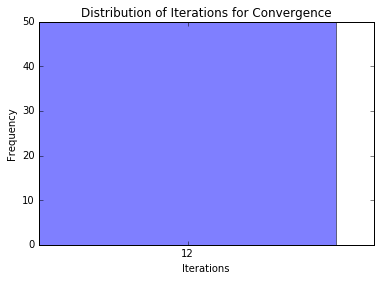

In [220]:
import collections
iterations = collections.OrderedDict(sorted(iterations.items()))

print(iterations)
y_pos = range(len(iterations))
performance = iterations.values()

print(iterations.keys())
plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, iterations.keys())
plt.ylabel('Frequency')
plt.xlabel('Iterations')
plt.title('Distribution of Iterations for Convergence')
 
plt.savefig("distribution2.png")
plt.show()